<a href="https://colab.research.google.com/github/arangoml/networkx-adapter/blob/doc_updates_nx/examples/IMDB_Networkx_Adapter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Node2Vec to Embed Viewers of a Movie using the ArangoDB IMDB NetworkX Adapter

This notebook provides the details of using the ArangoDB IMDB NetworkX adapter to develop a _node2vec_ embedding of the viewers of a movie from the _IMDB_ database. 

## Install Required Libraries 

<a href="https://colab.research.google.com/github/arangoml/networkx-adapter/blob/dgl_updates/examples/IMDB_Networkx_Adapter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!git clone -b doc_updates_nx https://github.com/arangoml/networkx-adapter.git
!rsync -av networkx-adapter/examples/ ./ --exclude=.git
!pip3 install networkx
!pip3 install matplotlib
!pip3 install --index-url https://test.pypi.org/simple/ adbnx-adapter==0.0.0.2.5.3
!pip3 install pyarango
!pip3 install python-arango
!pip install node2vec
!pip install seaborn

In [8]:
!rm creds.dat
!touch creds.dat

## Get a Oasis Connection

__Oasis__, the managed database service offering from ArangoDB, will be used for this exercise. This eliminates the need for setting up and configuring an instance of a database.

In [1]:
from adbnx_adapter.imdb_arangoDB_networkx_adapter import IMDBArangoDB_Networkx_Adapter
import oasis
con = oasis.getTempCredentials()

print()
print("https://{}:{}".format(con["hostname"], con["port"]))
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])


ma = IMDBArangoDB_Networkx_Adapter(conn=con)

Credentials expired.
Requesting new temp credentials.
Temp database ready to use.

https://d383fa0b596a.arangodb.cloud:8529
Username: TUTt59ijgodkinwewhdwgw01s
Password: TUTz0ydqif5c1n3hw3fb3xxqs
Database: TUTkkzahxo9h1d0m2kxdxdwo


## Create the Collections for the Database 

In [2]:
# Connect to the temp database
conn = oasis.connect(con)
db = conn[con["dbName"]]

In [3]:
import csv
import json
import requests
import sys
import oasis


from pyArango.connection import *
from pyArango.collection import Collection, Edges, Field
from pyArango.graph import Graph, EdgeDefinition
from pyArango.collection import BulkOperation as BulkOperation
from pyArango.collection import Collection, Field
from pyArango.graph import Graph, EdgeDefinition


class Users(Collection):
    _fields = {
        "user_id": Field(),
        "age": Field(),
        "gender": Field()
    }
    
class Movies(Collection):
    _fields = {
        "movie_id": Field(),
        "movie_title": Field(),
        "release_data": Field()
    }

class Ratings(Edges): 
    _fields = {
        #user_id and item_id are encoded by _from, _to 
        "rating": Field(),
        "timestamp": Field()
    }

class IMDBGraph(Graph) :
    _edgeDefinitions = [EdgeDefinition("Ratings", fromCollections=["Users"], toCollections=["Movies"])]
    _orphanedCollections = []

db.createCollection("Users")
db.createCollection("Movies")
db.createCollection("Ratings")
iMDBGraph = db.createGraph("IMDBGraph")

print("Collection/Graph Setup done.")

Collection/Graph Setup done.


## Load the Data 

In [4]:
collection = db["Users"]
with BulkOperation(collection, batchSize=100) as col:
    with open('data/users.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        # Skip header
        next(reader)
        for row in reader:
            user_id, age, gender, occupation, zip = tuple(row)
            doc = col.createDocument()
            doc["_key"] = user_id
#             doc["age"] = age
#             doc["gender"] = gender
            doc.save()

collection = db["Movies"]
with BulkOperation(collection, batchSize=100) as col:
    with open('data/movies.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        # Skip header
        next(reader)
        for row in reader:
            movie_id, movie_title, release_date, video_release_date, url, unknown, action, adventure, animation, childrens, comedy, crime, documentary, drama, fantasy, noir, horror, musical, mystery, romance, scifi, thriller, war, western = tuple(
                row)
            doc = col.createDocument()
            doc["_key"] = movie_id
#             doc["movie_title"] = movie_title
#             doc["release_date"] = release_date
            doc.save()

collection = db["Ratings"]
with BulkOperation(collection, batchSize=1000) as col:
    with open('data/ratings.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        # Skip header
        next(reader)
        for row in reader:
            user_id, movie_id, rating, timestamp = tuple(row)
            doc = col.createDocument()
            doc["_from"] = "Users/"+user_id
            doc["_to"] = "Movies/"+movie_id
            doc["ratings"] = rating
#             doc["timestamp"] = timestamp
            doc.save()

print("Import Done")

Import Done


## Specify the Graph Structure 

To use the IMDB Networkx Adapter, we need to specify the structure of the graph that we want to create. This is done with a simple dictionary. The details of creating the _Networkx_ graph are shown below.

In [5]:
imdb_attributes = {'vertexCollections': {'Users': {},
                                         'Movies': {}},
                   'edgeCollections': {'Ratings': {'_from', '_to', 'ratings'}}}

## Utility of the Networkx Interface
We just created a networkx graph for this problem, most analysis tasks with the graph require the following:
1. Understand the graph structure: We are interested in summary level statistics like number of nodes and edges. Distributional characteristics like degree distribution of nodes, clustering coefficients etc.
2. Investigate or explore a sub-graph of interest
3. Perform a learning problem on the graph.
Networkx provides API for tasks (1) and (2). It provides many algorithms for task (3). Many libraries for machine learning on graphs accept Graphs specified in as networkx graphs as input. Therefore, the networkx-adapter interface positions us well to perform analytics tasks on graphs. We will illustrate these ideas with an example.


## Obtain the networkx graph

In [6]:
g = ma.create_networkx_graph(
    graph_name='IMDBGraph',  graph_attributes=imdb_attributes)

## Get the user and movie nodes

In [10]:
user_nodes = [n for n in g.nodes() if n.startswith("Users")]
movie_nodes = [n for n in g.nodes() if n.startswith("Movies")]

## Structural Property Introspection: Number of Nodes and Edges

In [15]:
print("Number of Users are %d" % (len(user_nodes)))
print("Number of Movies are %d" % (len(movie_nodes)))
print("Number of Ratings are %d" % (len(list(g.edges()))))

Number of Users are 943
Number of Movies are 1682
Number of Ratings are 65499


## Convert the graph obtained from the interface to a bi-partite graph 

In [20]:
import networkx as nx
B = nx.Graph()
B.add_nodes_from(user_nodes, bipartite=0)
B.add_nodes_from(movie_nodes, bipartite=1)
B.add_edges_from(list(g.edges()))

In [21]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(B)

True

## Can we find users who have not rated a movie in common?
We can identify this by checking to see if the graph is connected. If the graph is connected, then there is a path between any two users in the graph.

In [22]:
nx.is_connected(B)

False

In [25]:
users = [n for n in B.nodes if B.nodes[n]['bipartite'] == 0]
movies = [n for n in B.nodes if B.nodes[n]['bipartite'] == 1]

## How many movies does a User rate?
This is a distribution. A review of the plot below will show the familiar long tailed distribution. Most viewers rate less than say 100 movies. There are some serious reviewers out there though. These are on the tail of the distribution.

In [52]:
degu, degm = bipartite.degrees(B, movies)

In [53]:
du = [v for k,v in degu]

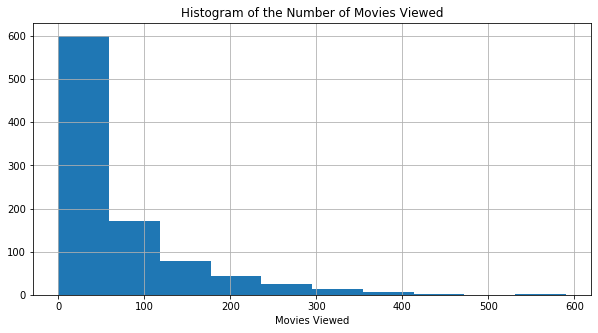

In [54]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
ax = plt.hist(du)
plt.title("Histogram of the Number of Movies Viewed")
plt.xlabel("Movies Viewed")
plt.grid(True)

## How many users rate a movie?
This is also a distribution that also has the long tailed behavior. Most mvoies are rated by less than 100 users. There are some movies that are rated by many viewers though.

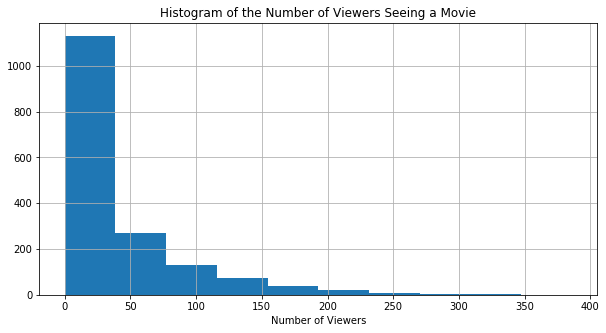

In [56]:
dm = [v for k,v in degm]
plt.rcParams['figure.figsize'] = [10, 5]
ax = plt.hist(dm)
plt.title("Histogram of the Number of Viewers Rating a Movie")
plt.xlabel("Number of Viewers")
plt.grid(True)

## Centrality Measures
We saw that movie ratings by users as well as movie viewership exhibit long tailed behavior. How do we formalize the observations about movie importance and the user's rating behavior in the given network? The notion of centrality measure is useful in this regard. Centrality measures identify the important nodes in a network. We will use degree centraility in this example (see the [documentation](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.centrality.degree_centrality.html) for details). In the illustrations below, we will capture the top 10 users and movies in terms of importance as determined by this measure 

In [74]:
dc= bipartite.degree_centrality(B, users)
sdcu = {}
sdcm = {}
for k, v in sorted(dc.items(),reverse=True, key=lambda item: item[1]):
    if k.startswith("Users"):
        sdcu[k] = v
    else:
        sdcm[k] = v

del dc

## List the top 10 users in terms of degree centrality
These guys rate a lot of movies

In [83]:
list(sdcu.keys())[:10]

['Users/405',
 'Users/13',
 'Users/276',
 'Users/450',
 'Users/234',
 'Users/303',
 'Users/416',
 'Users/655',
 'Users/181',
 'Users/393']

## List the top 10 movies in terms of degree centrality
These movies are rated by a lot of people

In [84]:
list(sdcm.keys())[:10]

['Movies/50',
 'Movies/258',
 'Movies/100',
 'Movies/288',
 'Movies/181',
 'Movies/286',
 'Movies/294',
 'Movies/1',
 'Movies/56',
 'Movies/98']

## How does this importance measure vary over the user community?
We can get a sense of this by viewing the distribution of this measure.

Text(0.5, 0, 'User Degree Centraility')

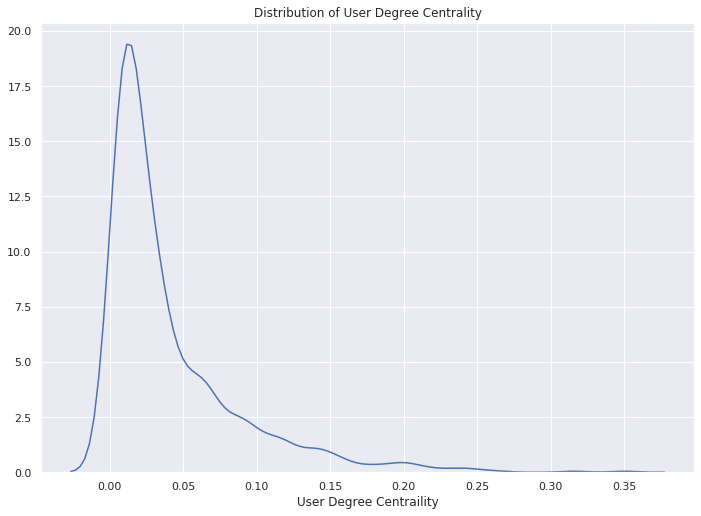

In [91]:
import seaborn as sns
import numpy as np
npvals = np.fromiter(sdcu.values(), dtype=float)
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(npvals, hist = False)
plt.title("Distribution of User Degree Centrality")
plt.xlabel("User Degree Centraility")


## How does this importance measure vary over the movie community?

Text(0.5, 0, 'Movie Degree Centraility')

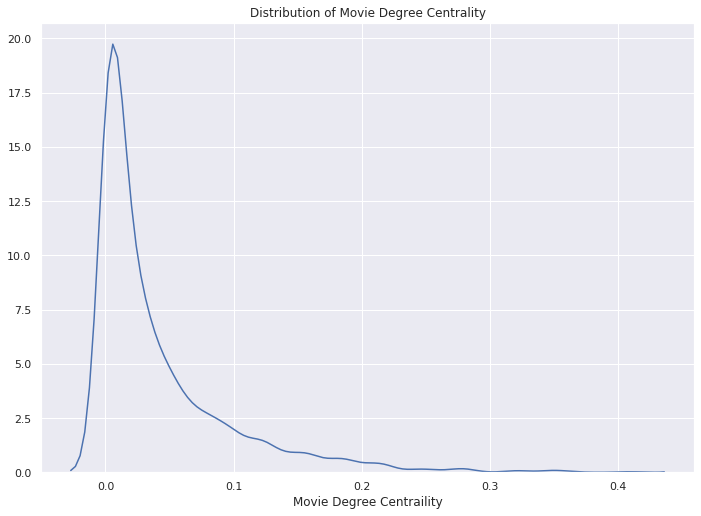

In [92]:
import seaborn as sns
import numpy as np
npvals = np.fromiter(sdcm.values(), dtype=float)
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(npvals, hist = False)
plt.title("Distribution of Movie Degree Centrality")
plt.xlabel("Movie Degree Centraility")


In [93]:
m4v = [t[0] for t in g.in_edges('Movies/4')]

## Analysis of a Subgraph
Now that we have information about characteristics of the dataset, let's illustrate the utility of the Networkx interface with machine learning tasks. For this purpose, consider the task of analyzing the group of users for a particular movie. To make this concrete, let's pick 'Movies/4'. We would like to understand the community of users who have rated this movie. For this purpose we will use Node2vec. Node2vec performs what is called representation learning. The idea is to encode the graph structure into a numerical representation. We can use visualization techniques such as the t Stochastic Nieghbor embedding to understand and visualize the data once we have this numerical representation. The Node2Vec library can work with Networkx graphs. Therefore, we are in a position to use Node2vec for our analysis.

## How similar are viewers of the movie 'Get Shorty'?
The notion of similarity relates to measures used to capture how similar two nodes in a network are to each other. There are various measures to capture similarity. In this example, we will use the __Jaccard__ similarity. We first get all pairs of users who have seen the movie and then compute the __Jaccard__ similarity between them. The details are shown below. Networkx provides an API for this purpose that we will use.

In [145]:
from itertools import combinations
m4vucmb = list(combinations(m4v, 2))

In [151]:
import networkx as nx
gp = g.to_undirected()
jcp = nx.jaccard_coefficient(gp, m4vucmb)

## Create a complete sub-graph for the viewers of 'Get Shorty' using the Jaccard Simlarity for the edge weights
We will construct a complete graph using the viewers of the movie "Get Shorty". The edge weight between a pair of users will be the Jaccard similarity

In [152]:
gs = nx.DiGraph()
jcpv = []
for u, v, p in jcp:
    gs.add_edge(u, v, weight=p)
    jcpv.append(p)
    #print('(%s, %s) -> %.8f' % (u, v, p))

## How many edges does the complete sub-graph have?

In [146]:
gs.number_of_edges()

9453

## What does the distribution of User Similarity look like?

Text(0.5, 0, 'Jaccard Similarity')

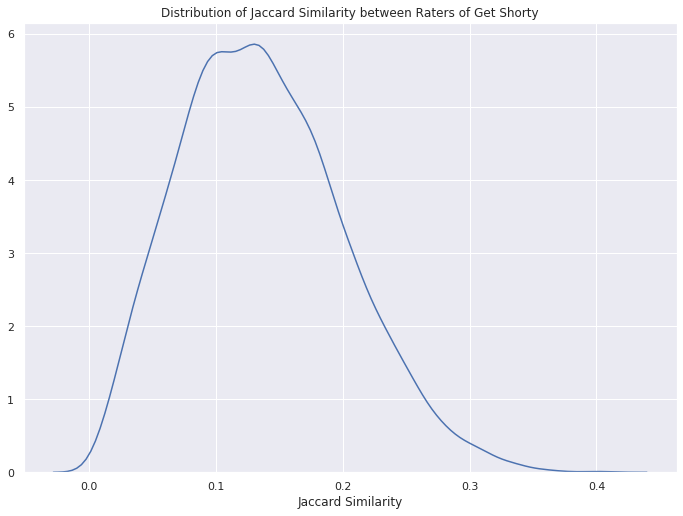

In [154]:
import seaborn as sns
import numpy as np
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(jcpv, hist = False)
plt.title("Distribution of Jaccard Similarity between Raters of Get Shorty")
plt.xlabel("Jaccard Similarity")

## Embed the sub-graph using Node2vec 

In [155]:
from node2vec import Node2Vec
node2vec = Node2Vec(gs, dimensions=64, walk_length=10, num_walks=30, workers=4)

Computing transition probabilities: 100%|██████████| 138/138 [00:01<00:00, 130.44it/s]


In [156]:
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [157]:
model.wv.most_similar(m4v[5])

[('Users/398', 0.9994795322418213),
 ('Users/645', 0.9994060397148132),
 ('Users/363', 0.9993206858634949),
 ('Users/537', 0.9993155002593994),
 ('Users/286', 0.9993100166320801),
 ('Users/271', 0.9993089437484741),
 ('Users/593', 0.9992958307266235),
 ('Users/219', 0.9992914795875549),
 ('Users/394', 0.9992674589157104),
 ('Users/345', 0.9992673397064209)]

__Using the Networkx adapter we have been able to perform a range of analysis tasks using the Networkx API. We were also able use the Networkx graph to obtain an embedding of a graph using Node2vec.__